In [118]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

In [119]:
# Load the dataset
try:
    data = pd.read_csv('NortheasterNFL.csv')  # Adjust the file path if necessary
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("File not found. Please check the path and filename.")

# Display basic info about the dataset
print("\nDataset Info:")
data_info = data.info()
print(data_info)

# Checking missing values in key columns
key_columns = ['yards_to_go', 'yard_line', 'down', 'score_diff', 'play_type']
missing_values = data[key_columns].isnull().sum()

print("\nMissing Values in Key Columns:")
print(missing_values)

Dataset loaded successfully.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35474 entries, 0 to 35473
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   game_id                   35474 non-null  object 
 1   week_num                  35474 non-null  int64  
 2   play_id                   35474 non-null  int64  
 3   drive_num                 35474 non-null  int64  
 4   quarter                   35474 non-null  int64  
 5   remaining_time            35474 non-null  object 
 6   yards_to_go               35474 non-null  int64  
 7   yard_line                 35474 non-null  int64  
 8   offensive_team            35474 non-null  object 
 9   defensive_team            35474 non-null  object 
 10  venue                     35474 non-null  object 
 11  score_diff                35474 non-null  int64  
 12  offensive_team_score      35474 non-null  int64  
 13  defensive_team_sc

In [120]:
# Drop unnecessary columns if present
columns_to_drop = ['game_id', 'play_id', 'offensive_team', 'defensive_team', 'venue', 'play_type.1']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns], errors='ignore')
print("\nUnnecessary columns dropped, if present.")

# Display summary statistics for key columns
key_columns = ['yards_to_go', 'yard_line', 'down', 'score_diff', 'play_type']
print("\nSummary Statistics for Key Columns:")
print(data[key_columns].describe())



Unnecessary columns dropped, if present.

Summary Statistics for Key Columns:
        yards_to_go     yard_line          down    score_diff
count  35474.000000  35474.000000  35474.000000  35474.000000
mean       8.449456     51.169504      1.822067      1.363562
std        3.940412     24.158595      0.841193     10.512418
min        1.000000      1.000000      1.000000    -40.000000
25%        6.000000     33.000000      1.000000     -4.000000
50%       10.000000     55.000000      2.000000      0.000000
75%       10.000000     72.000000      2.000000      7.000000
max       40.000000     99.000000      4.000000     56.000000


In [121]:
from sklearn.preprocessing import StandardScaler

# 1. Cap extreme values in score_diff (using IQR or specific limits)
def cap_outliers(df, column, lower_bound=None, upper_bound=None):
    # Calculate bounds using IQR if not provided
    if lower_bound is None or upper_bound is None:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)

cap_outliers(data, 'score_diff', -20, 20)  # Example bounds for score_diff

# 2. Standardize Numerical Features
scaler = StandardScaler()
data[['yards_to_go', 'yard_line', 'score_diff']] = scaler.fit_transform(data[['yards_to_go', 'yard_line', 'score_diff']])
print("\nNumerical features standardized.")

# 3. One-Hot Encode the 'down' Feature
data = pd.get_dummies(data, columns=['down'], prefix='down')
print("\n'Down' feature one-hot encoded.")

# Display the first few rows to verify transformations
print("\nTransformed Data Sample:")
print(data.head())



Numerical features standardized.

'Down' feature one-hot encoded.

Transformed Data Sample:
   week_num  drive_num  quarter remaining_time  yards_to_go  yard_line  \
0         1          1        1          15:00     0.393503   0.986433   
1         1          1        1          14:29    -1.382985   0.696677   
2         1          1        1          14:25    -1.382985   0.696677   
3         1          2        1          14:09     0.393503   1.483157   
4         1          2        1          13:34    -0.875417   1.276189   

   score_diff  offensive_team_score  defensive_team_score  score_gap  ...  \
0   -0.121689                     0                     0          0  ...   
1   -0.121689                     0                     0          0  ...   
2   -0.121689                     0                     0          0  ...   
3   -0.121689                     0                     0          0  ...   
4   -0.121689                     0                     0          0  ...   



Summary Statistics for Numerical Features:
        yards_to_go     yard_line    score_diff
count  3.547400e+04  3.547400e+04  3.547400e+04
mean  -1.518271e-16  9.894799e-17 -2.083116e-17
std    1.000014e+00  1.000014e+00  1.000014e+00
min   -1.890554e+00 -2.076702e+00 -2.247828e+00
25%   -6.216331e-01 -7.521034e-01 -5.469171e-01
50%    3.935035e-01  1.585585e-01 -1.216893e-01
75%    3.935035e-01  8.622517e-01  6.224593e-01
max    8.007028e+00  1.979882e+00  2.004450e+00


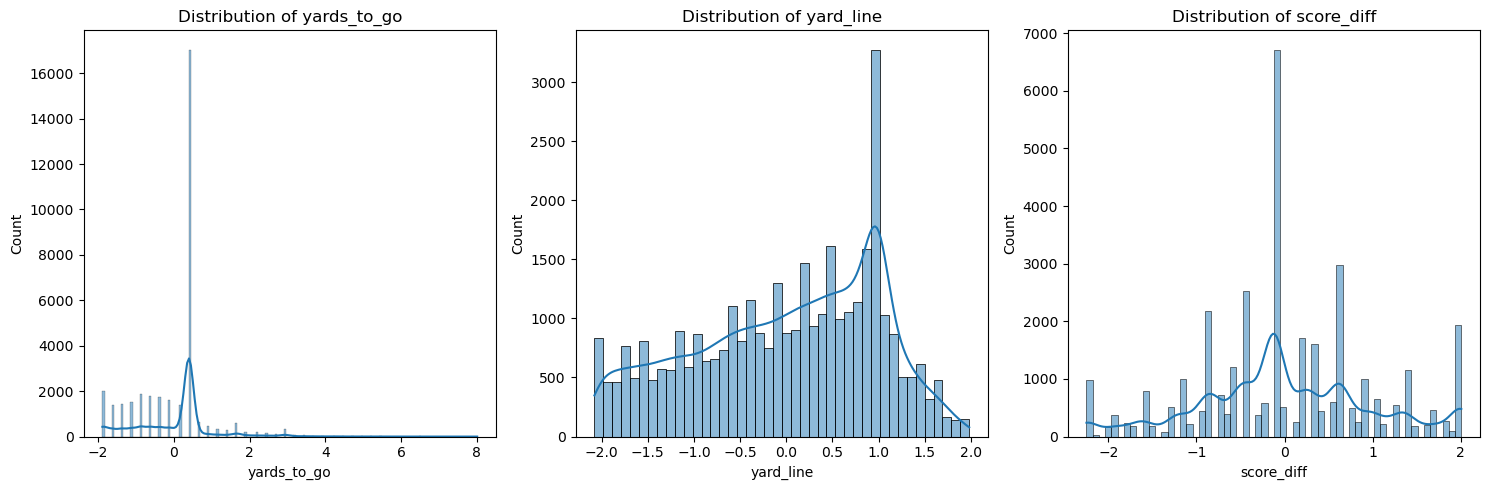

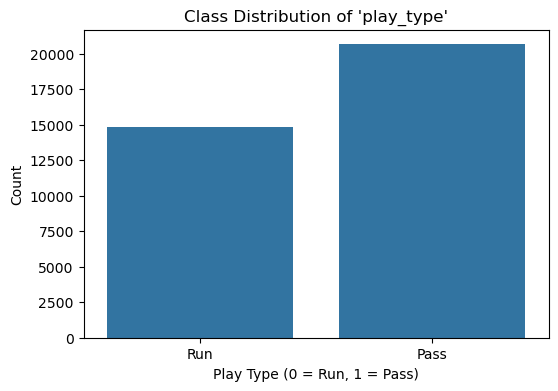

In [122]:
# 1. Summary Statistics for Numerical Features
print("\nSummary Statistics for Numerical Features:")
print(data[['yards_to_go', 'yard_line', 'score_diff']].describe())

# 2. Distribution of Numeric Features
numeric_features = ['yards_to_go', 'yard_line', 'score_diff']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

# 3. Count Plot for 'play_type'
plt.figure(figsize=(6, 4))
sns.countplot(x='play_type', data=data)
plt.title("Class Distribution of 'play_type'")
plt.xlabel("Play Type (0 = Run, 1 = Pass)")
plt.ylabel("Count")
plt.show()


In [147]:
# Define numerical and categorical columns
numerical_columns = ['week_num', 'drive_num', 'quarter', 'yards_to_go', 'yard_line', 'score_diff',
                     'offensive_team_score', 'defensive_team_score', 'score_gap', 'prev_play_yards',
                     'down_yards_to_go', 'pass_attempts', 'pass_success', 'pass_success%', 'rush_attempts',
                     'rush_success', 'rush_success%', 'def_pass_attempts', 'def_pass_success',
                     'def_pass_success%', 'yards_gained', 'run_attempts', 'total_attempts', 'situation_running']

categorical_columns = ['down', 'in_red_zone', 'last_two_minutes_quarter', 'last_two_minutes_half',
                       'short_yardage', 'within_one_score', 'punt_territory', 'offensive_team', 
                       'defensive_team', 'venue', 'play_type']

In [125]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Define the missing categorical columns and add them if necessary
required_columns = ['offensive_team', 'defensive_team', 'venue']
for col in required_columns:
    if col not in data_cleaned.columns:
        print(f"Adding missing column '{col}' with placeholder values.")
        data_cleaned[col] = 'Unknown'  # Assign a default placeholder value

# Encode categorical columns
for col in categorical_columns:
    if col in data_cleaned.columns:
        # Handle missing values in categorical columns if any
        data_cleaned[col] = data_cleaned[col].fillna('Unknown')
        data_cleaned[col] = LabelEncoder().fit_transform(data_cleaned[col])
    else:
        print(f"Warning: Column '{col}' not found in data_cleaned.")

# Standardize numerical columns
scaler = StandardScaler()
# Only standardize columns that are present in the data
numerical_cols_to_scale = [col for col in numerical_columns if col in data_cleaned.columns]
data_cleaned[numerical_cols_to_scale] = scaler.fit_transform(data_cleaned[numerical_cols_to_scale])

print("\nCategorical columns encoded and numerical columns standardized.")



Categorical columns encoded and numerical columns standardized.


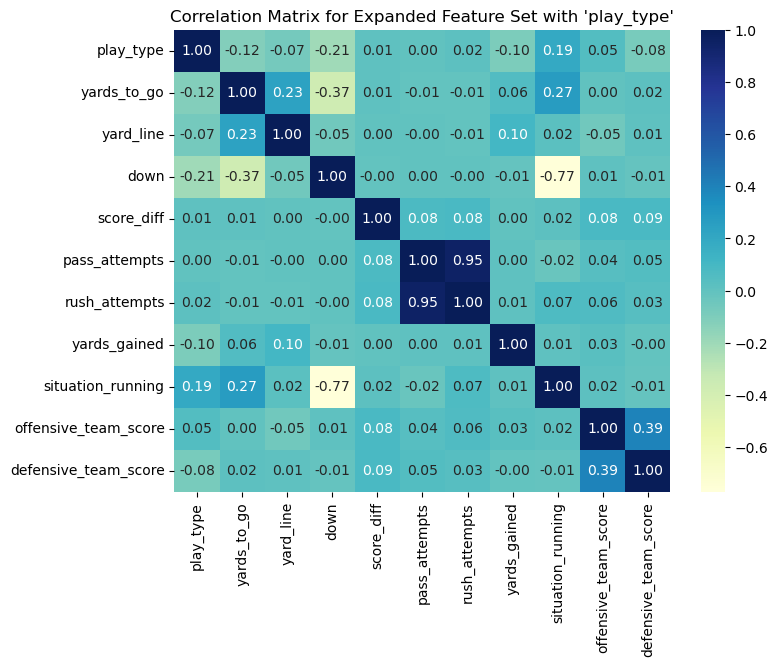

In [153]:
# Select more features for correlation analysis
expanded_correlation_data = data_cleaned[['play_type', 'yards_to_go', 'yard_line', 'down', 'score_diff', 
                                          'pass_attempts', 'rush_attempts', 'yards_gained', 'situation_running', 
                                          'offensive_team_score', 'defensive_team_score']]

# Calculate the correlation matrix
expanded_correlation_matrix = expanded_correlation_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(expanded_correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix for Expanded Feature Set with 'play_type'")
plt.show()

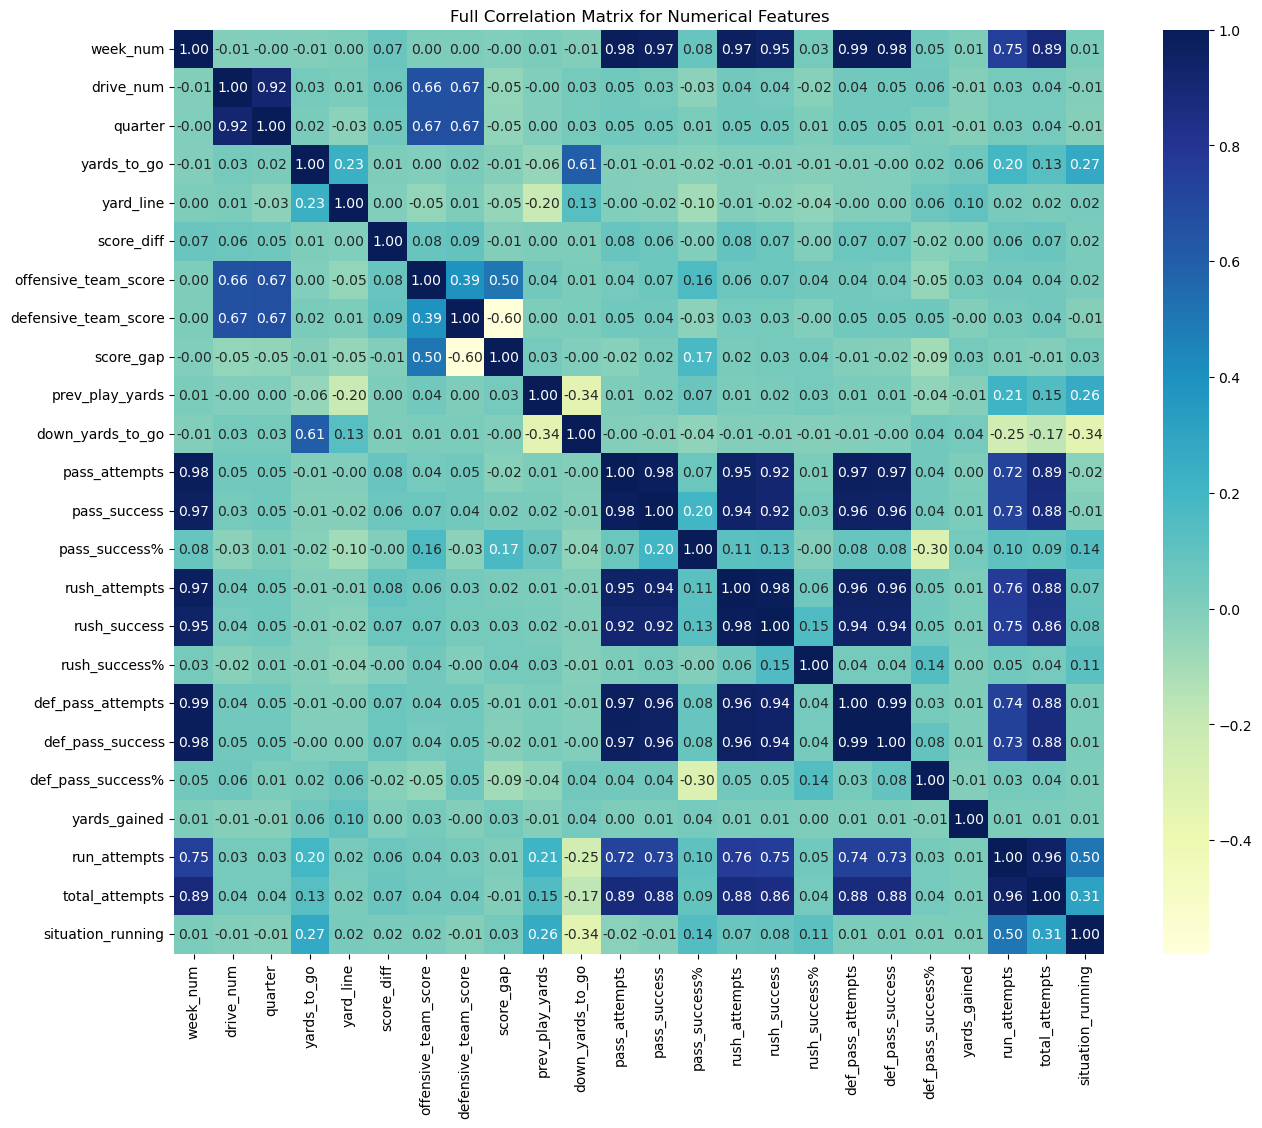

In [127]:
# Calculate the correlation matrix for all numerical features
full_correlation_matrix = data_cleaned[numerical_columns].corr()

# Plot the full correlation matrix as a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(full_correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Full Correlation Matrix for Numerical Features")
plt.show()



In [128]:
# Define a function to remove or cap outliers based on the IQR method
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap values outside of bounds
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    print(f"Outliers capped for {column}.")

# List of columns to apply outlier removal
columns_to_clean = ['yards_to_go', 'yard_line', 'down', 'score_diff']

# Apply outlier removal to each specified column
for col in columns_to_clean:
    cap_outliers(data_cleaned, col)

# Display the results to verify
print("\nOutlier removal applied. Summary statistics after capping:")
print(data_cleaned[columns_to_clean].describe())



Outliers capped for yards_to_go.
Outliers capped for yard_line.
Outliers capped for down.
Outliers capped for score_diff.

Outlier removal applied. Summary statistics after capping:
        yards_to_go     yard_line          down    score_diff
count  3.464000e+04  3.464000e+04  34640.000000  3.464000e+04
mean  -6.358783e-18  1.640976e-17      0.769717 -3.281953e-18
std    1.000014e+00  1.000014e+00      0.779624  1.000014e+00
min   -2.132510e+00 -2.091530e+00      0.000000 -2.251443e+00
25%   -6.953252e-01 -7.654262e-01      0.000000 -5.432647e-01
50%    4.544225e-01  1.462700e-01      1.000000 -1.291609e-01
75%    4.544225e-01  8.507625e-01      1.000000  5.955208e-01
max    2.179044e+00  1.969662e+00      2.000000  2.303699e+00


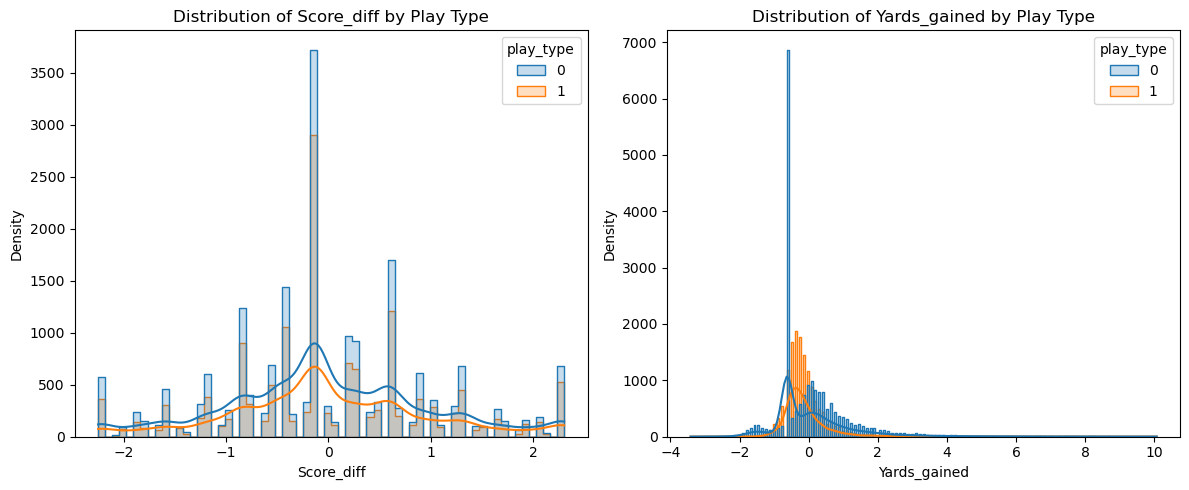

In [129]:
key_features = ['score_diff', 'yards_gained']
plt.figure(figsize=(12, 5))
for i, col in enumerate(key_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(data=data_cleaned, x=col, hue='play_type', kde=True, element='step')
    plt.title(f'Distribution of {col.capitalize()} by Play Type')
    plt.xlabel(col.capitalize())
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


Initial class distribution in 'play_type':
play_type
0    20118
1    14522
Name: count, dtype: int64

SMOTE applied successfully.

Class distribution after applying SMOTE:
play_type
1    20118
0    20118
Name: count, dtype: int64


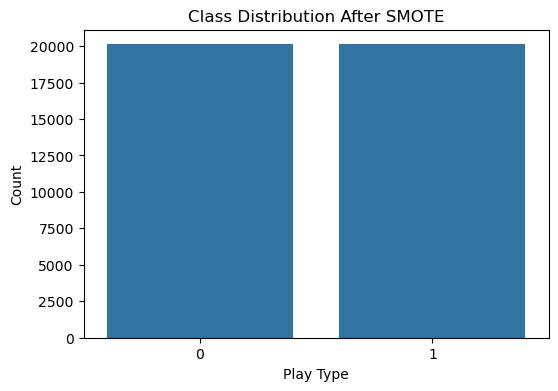

In [130]:
# Separate features and target variable
X = data_cleaned[['yards_to_go', 'yard_line', 'score_diff']]
y = data_cleaned['play_type']

# Check initial class distribution
print("Initial class distribution in 'play_type':")
print(y.value_counts())

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
try:
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print("\nSMOTE applied successfully.")
except ValueError as e:
    print("Error with SMOTE:", e)

# Confirm new class distribution
print("\nClass distribution after applying SMOTE:")
print(y_balanced.value_counts())

# Visualize the new class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_balanced)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Play Type")
plt.ylabel("Count")
plt.show()


In [131]:
# Split data into training and test sets with balanced class representation
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define new K values to test and store results
k_values = [3, 7, 11]
results = {}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Use cross-validation for more robust performance evaluation
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    knn.fit(X_train, y_train)  # Train model on full training set after cross-validation
    y_pred = knn.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    # Store results for this K value
    results[k] = {
        'cv_accuracy': np.mean(cv_scores),
        'test_accuracy': accuracy,
        'classification_report': report
    }

# Display results in an ordered and readable format
for k, metrics in results.items():
    print(f"Model Evaluation Results for K={k}")
    print("=========================")
    print(f"Cross-Validated Accuracy: {metrics['cv_accuracy']:.2%}")
    print(f"Test Set Accuracy: {metrics['test_accuracy']:.2%}\n")
    print("Classification Report:")
    print(metrics['classification_report'])
    print("-" * 50)


Model Evaluation Results for K=3
Cross-Validated Accuracy: 58.27%
Test Set Accuracy: 58.75%

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      6036
           1       0.58      0.61      0.60      6035

    accuracy                           0.59     12071
   macro avg       0.59      0.59      0.59     12071
weighted avg       0.59      0.59      0.59     12071

--------------------------------------------------
Model Evaluation Results for K=7
Cross-Validated Accuracy: 58.25%
Test Set Accuracy: 58.99%

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.58      6036
           1       0.59      0.62      0.60      6035

    accuracy                           0.59     12071
   macro avg       0.59      0.59      0.59     12071
weighted avg       0.59      0.59      0.59     12071

--------------------------------------------------
Model Evalua

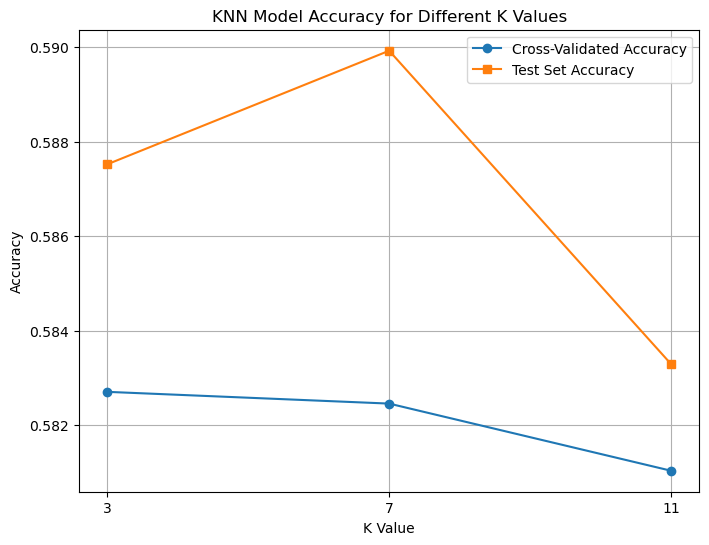

In [157]:
import matplotlib.pyplot as plt

# Extract results for plotting
k_values = list(results.keys())
cv_accuracies = [metrics['cv_accuracy'] for metrics in results.values()]
test_accuracies = [metrics['test_accuracy'] for metrics in results.values()]

# Plotting cross-validated and test set accuracies
plt.figure(figsize=(8, 6))
plt.plot(k_values, cv_accuracies, marker='o', linestyle='-', label='Cross-Validated Accuracy')
plt.plot(k_values, test_accuracies, marker='s', linestyle='-', label='Test Set Accuracy')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy for Different K Values')
plt.legend()
plt.grid(True)
plt.xticks(k_values)
plt.show()
